In [11]:
import numpy as np
import pandas as pd
#import numpy and pandas libraries

In [12]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import matplotlib.pyplot as plt

#import necessary libraries in Pytorch and matplotlib

In [13]:
dataset_folder = "../../dataset/"
oil_df = pd.read_csv(dataset_folder + 'oil.csv')
coin_df = pd.read_csv(dataset_folder + 'coin.csv')
microsoft_df = pd.read_csv(dataset_folder + 'microsoft.csv')
sp500_df = pd.read_csv(dataset_folder + 'sp500.csv')
artificial1_df = pd.read_csv(dataset_folder + 'Artificial_trend.csv')
artificial2_df = pd.read_csv(dataset_folder + 'Artificial_trend1.csv')

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#we import MinMaxScaler function from sklearn to scale our dataset and also make a instance of that

In [15]:
def format_train_test (batch_size, data, percent, num_predicts, column_i):
    """
    Here is the function to make train set, test set, and label for each of them from the dataframe.We first want to see how many
    We want to find the percent of data used for train set. Then, we find length of train data so that it could divisible by batch 
    size. Then we scale the dataset and make train set and label for each by iterating through the dataset until and make them lag
    by number of predict steps we want until we have desired amount of data for train process. Then, we find the length for test
    set and we repeat the same process as forming train set and its label.

    Parameters
    ----------
    batch_size : int
        Num of batch size split
    data : DataFrame
        The dataframe that is needed
    percent : double
        Percentage split between train and test. e.g. 0.2 means 80% train and 20% test
    num_predicts : int
        Nume of predictions
    column_i : 
        The column in the data that you want to make train test set from
    """

    # prepare train data
    length_train = int(data.shape[0]*(1-percent))
    a1 = length_train//batch_size
    length_train = batch_size*a1    # get length of training
    train_data = data.iloc[:, column_i:column_i+1].values    # get desired value columns
    train_data = scaler.fit_transform(train_data)   # 0-1 scale data
    # splitting up data to train and label
    train_set = []
    train_label = []
    for i in range(length_train):
        train_set.append(train_data[i:i + num_predicts])
        train_label.append(train_data[i + num_predicts:i + 2*num_predicts])
    
    # prepare test data
    length_test = int(data.shape[0] - length_train - 4*num_predicts)
    a2 = length_test//batch_size
    length_test = int(batch_size*a2) 
    test = data.iloc[:, column_i:column_i+1].values
    test = scaler.fit_transform(test)
    test_data = test[length_train + 2*num_predicts:length_train + length_test + 4*num_predicts]
    test_set = []
    test_label = []
    for j in range(length_test):
        test_set.append(test_data[j:j + num_predicts])
        test_label.append(test_data[j + num_predicts:j + 2*num_predicts])
    
    train_set = np.reshape(np.array(train_set), (np.array(train_set).shape[0], np.array(train_set).shape[1], 1))
    train_label = np.reshape(np.array(train_label), (np.array(train_label).shape[0], np.array(train_label).shape[1],1))
    test_set = np.reshape(np.array(test_set) ,(np.array(test_set).shape[0], np.array(test_set).shape[1], 1))
    test_label = np.reshape(np.array(test_label), (np.array(test_label).shape[0], np.array(test_label).shape[1],1))
    
    return train_set, train_label, test_set, test_label, length_test


In [16]:
coin_df

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.000000e+00,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.000000e+00,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.000000e+00,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.000000e+00,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.000000e+00,1.085995e+09
...,...,...,...,...,...,...,...,...,...,...
2986,2987,Bitcoin,BTC,2021-07-02 23:59:59,33939.588699,32770.680780,33549.600177,33897.048590,3.872897e+10,6.354508e+11
2987,2988,Bitcoin,BTC,2021-07-03 23:59:59,34909.259899,33402.696536,33854.421362,34668.548402,2.438396e+10,6.499397e+11
2988,2989,Bitcoin,BTC,2021-07-04 23:59:59,35937.567147,34396.477458,34665.564866,35287.779766,2.492431e+10,6.615748e+11
2989,2990,Bitcoin,BTC,2021-07-05 23:59:59,35284.344430,33213.661034,35284.344430,33746.002456,2.672155e+10,6.326962e+11


In [17]:
class biRNN_model(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim1, hidden_dim2, batch_size, num_layers=2):
        super(biRNN_model, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.batch_size = batch_size
        self.num_layers = num_layers

        # padding first linear layer
        # self.first_linear = nn.Linear(self.input_dim, self.input_dim)

        # two biRNN layers
        self.bi_rnn1 = nn.RNN(
                            input_size=self.input_dim,
                            hidden_size=self.hidden_dim1,
                            num_layers=self.num_layers,
                            batch_first=True,
                            bidirectional=True
                            )

        # dense layer for prediction
        self.last_linear = nn.Linear(self.hidden_dim2*2, self.output_dim)

    def forward(self, x, hidden_state):
        # s0 = self.first_linear(x)
        s1, self.hidden = self.bi_rnn1(x, hidden_state)
        return self.last_linear(s1)

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.num_layers * 2, batch_size, self.hidden_dim1).zero_()
        return hidden
        # return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim1),
                # torch.zeros(self.num_layers, self.batch_size, self.hidden_dim1))

In [18]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device
# we check for the availablibility of GPU to use for training

device(type='cuda', index=0)

In [19]:
def train_test(train_tensor, test_tensor, device, batch_size, iterations, isL1Loss, learning_rate=0.001):
    model = biRNN_model(1,5,5,5,64)
    model = model.to(device)
    criterion = nn.L1Loss() if isL1Loss else nn.MSELoss() 
    optimizer = optim.Adam(model.parameters(), learning_rate)
    tr = []
    te = []
    predict = []
    values = []
    loss_name = "L1" if isL1Loss else "MSE"

    # reset parameters
    for layer in model.children():
        layer.reset_parameters()

    # loop through epochs
    for i in range(iterations):
        h0 = model.init_hidden(batch_size)    # initialize parameters
        h = h0.to(device)   # push parameters to device

        for (x,y) in train_tensor:
            x, y = x.to(device), y.to(device)
            y_hat = model(x.float(), h)
            loss = criterion(y_hat, y.float())
            optimizer.zero_grad()
            h = h.detach()
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            h01 = model.init_hidden(batch_size)
            h1 = h01.to(device)
            lost_val = 0

            for (x1, y1) in test_tensor:
                x1, y1 = x1.to(device), y1.to(device)
                y_hat1 = model(x1.float(), h1)
                loss1 = criterion(y_hat1, y1.float())
                lost_val += loss1.item()
                h1 = h1.detach()
                if i == (iterations-1):
                    predict.append(y_hat1)
                    values.append(y1)
                
            lost_val /= len(x1)
            tr.append(loss.item())
            te.append(lost_val)
            print(f"Iteration {i}\n********************")
            print('The {} loss for train is: {}'.format(loss_name, loss.item()))
            print('The {} loss for test is: {}'.format(loss_name, loss.item()))
             
            for j in range(len(predict)):
                predict[j] = predict[j].cpu().numpy()
                values[j] = values[j].cpu().numpy()


    return i, tr, te, np.array(predict).reshape(-1)[::5], np.array(values).reshape(-1)
#Here we create function to do the training and validation process. We iterate through number of epochs, make initial state for model
#and iterate through each data batch to do prediction, compute the loss and do backward propagation to improve the parameters. In
#the same epoch, I also apply the model to make prediction on test dataset to keep track of model performace more closely. I also
#print iteration round, train loss, and test loss. I also return them to do some plots later.

SyntaxError: invalid syntax (Temp/ipykernel_32016/568337195.py, line 52)

In [ ]:
def plot_predictions(predict, values):
    plt.figure(figsize=(14,10))
    plt.plot(predict, "-o", color="g", label="Predicted")
    plt.plot(values, color="b", label="Actual")
    plt.ylabel('Bitcoin price')
    plt.xlabel('Time Points')
    plt.legend()

def plot_tr_te(iterations,tr,te,title):
    t = np.arange(0,iterations+1)
    y1 = np.array(tr)
    y2 = np.array(te)
    plt.figure(figsize=(6, 4))
    plt.title('Plot of train and test loss vs iterations for '+title)
    plt.plot(t, y1, color="g")
    plt.plot(t, y2, color="b")
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend(["train", "test"])

# Artificial Dataset 1

In [ ]:
train_set, train_label, test_set, test_label, length_test = format_train_test(
                                                                batch_size=64,
                                                                data=artificial1_df,
                                                                percent=0.2,
                                                                num_predicts=5,
                                                                column_i=1
                                                                )

train_set, train_label, test_set, test_label = map(torch.tensor,(train_set, train_label, test_set, test_label))

train = TensorDataset(train_set, train_label)
train_tensor = DataLoader(train, batch_size = 64, shuffle=False)

test = TensorDataset(test_set, test_label)
test_tensor = DataLoader(test, batch_size= 64, shuffle=False)

#we then make train, test sets, and their labels. Then we convert them to torch tensors and make torch dataset and use DataLoader to 
#to make data ready for training and testing. Here batch size is 64, percent of test set is 0.2 and 5 predictions steps

## MSE

In [ ]:
iterations, tr, te, predict, values = train_test(train_tensor, test_tensor, device,64,100, False, learning_rate=0.001)

C:\Users\goodu\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64, 5, 1])) that is different to the input size (torch.Size([64, 5, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Iteration 0
********************
The loss for train is:  0.007790769916027784
The loss for test is:  0.010847999103134498
Iteration 1
********************
The loss for train is:  0.004178442060947418
The loss for test is:  0.009545480854285415
Iteration 2
********************
The loss for train is:  0.0037498793099075556
The loss for test is:  0.007707764314545784
Iteration 3
********************
The loss for train is:  0.003700826084241271
The loss for test is:  0.005788815858977614
Iteration 4
********************
The loss for train is:  0.0034436630085110664
The loss for test is:  0.0038644694250251632
Iteration 5
********************
The loss for train is:  0.0021700975485146046
The loss for test is:  0.0022183405144460266
Iteration 6
********************
The loss for train is:  0.0010849140817299485
The loss for test is:  0.0012324520657784888
Iteration 7
********************
The loss for train is:  0.0009427060140296817
The loss for test is:  0.0008161702016877825
Iteration 8
***

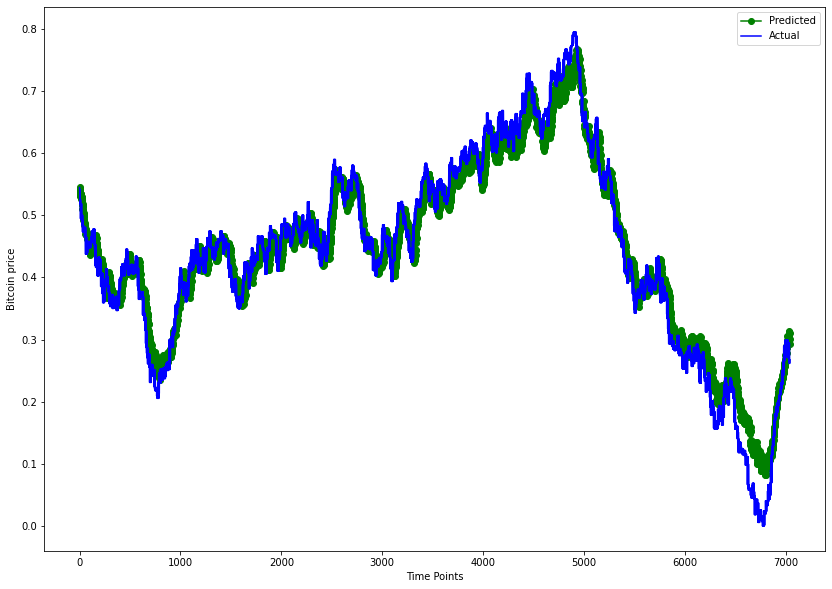

In [ ]:
plot_predictions(predict, values)

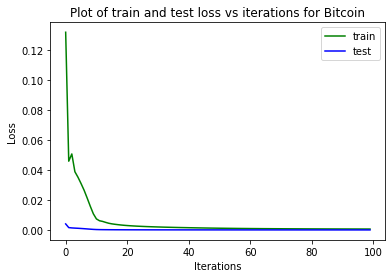

In [ ]:
plot_tr_te(iterations,tr,te,'Artificial Data 1')

## L1

In [ ]:
iterations, tr, te, predict, values = train_test(train_tensor, test_tensor, device,64,100, True, learning_rate=0.001)

C:\Users\goodu\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64, 5, 1])) that is different to the input size (torch.Size([64, 5, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Iteration 0
********************
The loss for train is:  0.007790769916027784
The loss for test is:  0.010847999103134498
Iteration 1
********************
The loss for train is:  0.004178442060947418
The loss for test is:  0.009545480854285415
Iteration 2
********************
The loss for train is:  0.0037498793099075556
The loss for test is:  0.007707764314545784
Iteration 3
********************
The loss for train is:  0.003700826084241271
The loss for test is:  0.005788815858977614
Iteration 4
********************
The loss for train is:  0.0034436630085110664
The loss for test is:  0.0038644694250251632
Iteration 5
********************
The loss for train is:  0.0021700975485146046
The loss for test is:  0.0022183405144460266
Iteration 6
********************
The loss for train is:  0.0010849140817299485
The loss for test is:  0.0012324520657784888
Iteration 7
********************
The loss for train is:  0.0009427060140296817
The loss for test is:  0.0008161702016877825
Iteration 8
***

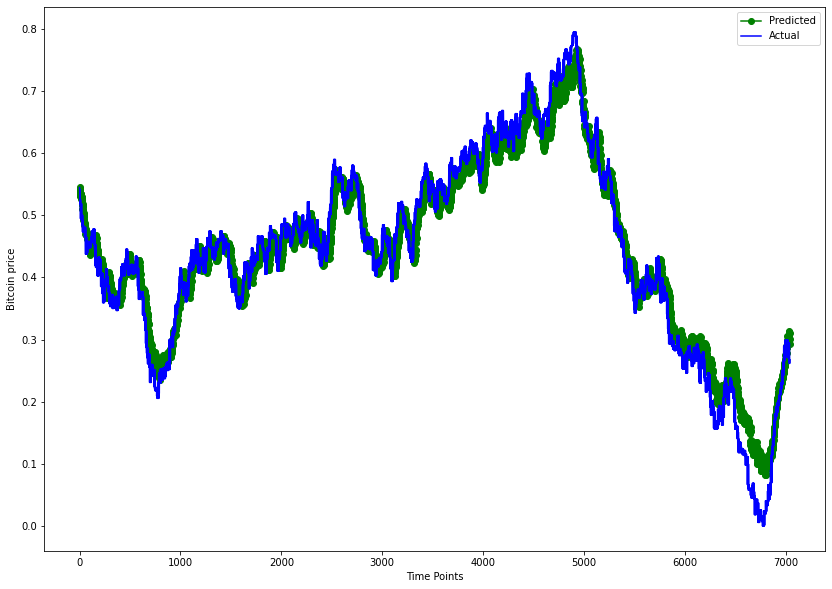

In [ ]:
plot_predictions(predict, values)

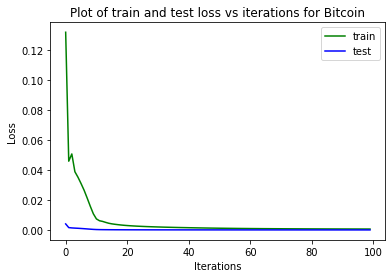

In [ ]:
plot_tr_te(iterations,tr,te,'Artificial Data 1')

# Artificial Dataset 2

In [ ]:
train_set, train_label, test_set, test_label, length_test = format_train_test(
                                                                batch_size=64,
                                                                data=artificial2_df,
                                                                percent=0.2,
                                                                num_predicts=5,
                                                                column_i=1
                                                                )

train_set, train_label, test_set, test_label = map(torch.tensor,(train_set, train_label, test_set, test_label))

train = TensorDataset(train_set, train_label)
train_tensor = DataLoader(train, batch_size = 64, shuffle=False)

test = TensorDataset(test_set, test_label)
test_tensor = DataLoader(test, batch_size= 64, shuffle=False)

#we then make train, test sets, and their labels. Then we convert them to torch tensors and make torch dataset and use DataLoader to 
#to make data ready for training and testing. Here batch size is 64, percent of test set is 0.2 and 5 predictions steps

In [ ]:
iterations, tr, te, predict, values = train_test(model,train_tensor,test_tensor,criterion,optimizer,device,64,100)

C:\Users\goodu\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64, 5, 1])) that is different to the input size (torch.Size([64, 5, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Iteration 0
********************
The loss for train is:  0.05652831122279167
The loss for test is:  0.03200697283318732
Iteration 1
********************
The loss for train is:  0.021062564104795456
The loss for test is:  0.017049147885700222
Iteration 2
********************
The loss for train is:  0.010727264918386936
The loss for test is:  0.011757272739487235
Iteration 3
********************
The loss for train is:  0.00707133999094367
The loss for test is:  0.0094939231803437
Iteration 4
********************
The loss for train is:  0.005871317815035582
The loss for test is:  0.008430652125753113
Iteration 5
********************
The loss for train is:  0.006134672090411186
The loss for test is:  0.00802736929654202
Iteration 6
********************
The loss for train is:  0.008110654540359974
The loss for test is:  0.008178401651093736
Iteration 7
********************
The loss for train is:  0.011815344914793968
The loss for test is:  0.008402372899581678
Iteration 8
******************

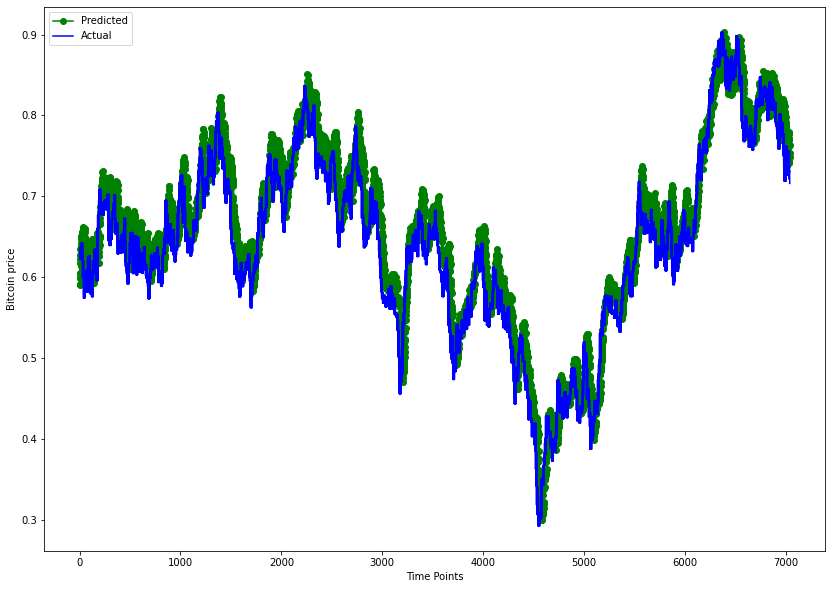

In [ ]:
plot_predictions(predict, values)

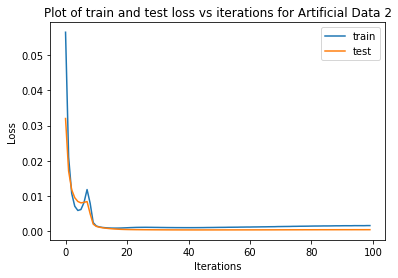

In [ ]:
plot_tr_te(iterations,tr,te,'Artificial Data 2')

# Microsoft Stock

In [ ]:
train_set, train_label, test_set, test_label, length_test = format_train_test(
                                                                batch_size=64,
                                                                data=microsoft_df,
                                                                percent=0.2,
                                                                num_predicts=5,
                                                                column_i=1
                                                                )

train_set, train_label, test_set, test_label = map(torch.tensor,(train_set, train_label, test_set, test_label))

train = TensorDataset(train_set, train_label)
train_tensor = DataLoader(train, batch_size = 64, shuffle=False)

test = TensorDataset(test_set, test_label)
test_tensor = DataLoader(test, batch_size= 64, shuffle=False)

#we then make train, test sets, and their labels. Then we convert them to torch tensors and make torch dataset and use DataLoader to 
#to make data ready for training and testing. Here batch size is 64, percent of test set is 0.2 and 5 predictions steps

In [ ]:
iterations, tr, te, predict, values = train_test(model,train_tensor,test_tensor,criterion,optimizer,device,64,100)

C:\Users\goodu\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64, 5, 1])) that is different to the input size (torch.Size([64, 5, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Iteration 0
********************
The loss for train is:  0.0500095933675766
The loss for test is:  0.017424975405447185
Iteration 1
********************
The loss for train is:  0.09674802422523499
The loss for test is:  0.026899227872490883
Iteration 2
********************
The loss for train is:  0.08727674186229706
The loss for test is:  0.0249344645999372
Iteration 3
********************
The loss for train is:  0.07422616332769394
The loss for test is:  0.02290273248218
Iteration 4
********************
The loss for train is:  0.07422635704278946
The loss for test is:  0.022721869871020317
Iteration 5
********************
The loss for train is:  0.0720844715833664
The loss for test is:  0.02211554627865553
Iteration 6
********************
The loss for train is:  0.06827037781476974
The loss for test is:  0.021218362264335155
Iteration 7
********************
The loss for train is:  0.06433124095201492
The loss for test is:  0.020233791787177324
Iteration 8
********************
The loss

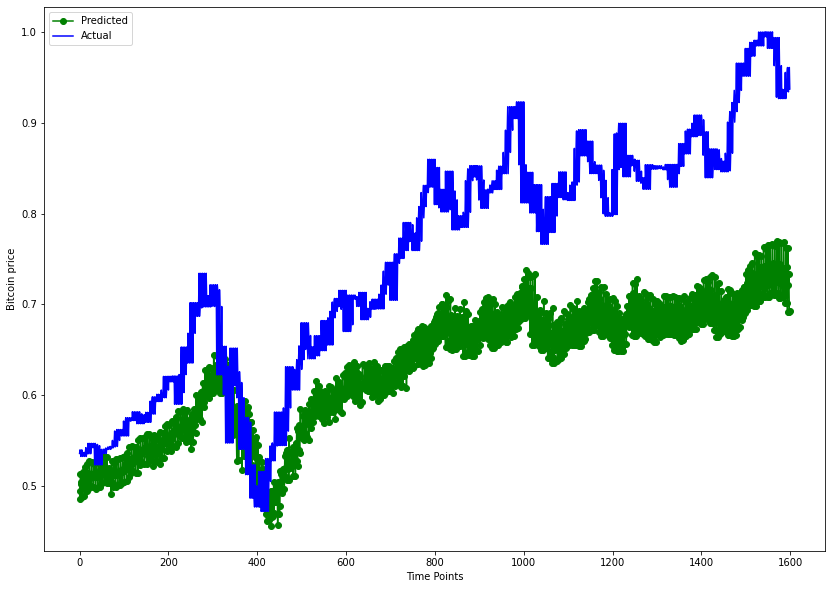

In [ ]:
plot_predictions(predict, values)

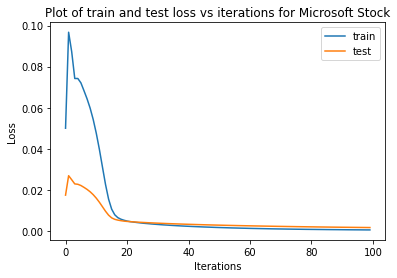

In [ ]:
plot_tr_te(iterations,tr,te,'Microsoft Stock')

# Crude Oil

In [ ]:
oil_df = oil_df[oil_df.DCOILBRENTEU != "."]
train_set, train_label, test_set, test_label, length_test = format_train_test(
                                                                batch_size=64,
                                                                data=oil_df,
                                                                percent=0.2,
                                                                num_predicts=5,
                                                                column_i=1
                                                                )

train_set, train_label, test_set, test_label = map(torch.tensor,(train_set, train_label, test_set, test_label))

train = TensorDataset(train_set, train_label)
train_tensor = DataLoader(train, batch_size = 64, shuffle=False)

test = TensorDataset(test_set, test_label)
test_tensor = DataLoader(test, batch_size= 64, shuffle=False)

#we then make train, test sets, and their labels. Then we convert them to torch tensors and make torch dataset and use DataLoader to 
#to make data ready for training and testing. Here batch size is 64, percent of test set is 0.2 and 5 predictions steps

In [ ]:
iterations, tr, te, predict, values = train_test(model,train_tensor,test_tensor,criterion,optimizer,device,64,100)

C:\Users\goodu\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64, 5, 1])) that is different to the input size (torch.Size([64, 5, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Iteration 0
********************
The loss for train is:  0.13216142356395721
The loss for test is:  0.004073576419614255
Iteration 1
********************
The loss for train is:  0.045988671481609344
The loss for test is:  0.0016082541114883497
Iteration 2
********************
The loss for train is:  0.050833672285079956
The loss for test is:  0.0013944522943347692
Iteration 3
********************
The loss for train is:  0.0389467254281044
The loss for test is:  0.001266936116735451
Iteration 4
********************
The loss for train is:  0.0352860726416111
The loss for test is:  0.0011556490935618058
Iteration 5
********************
The loss for train is:  0.03106120601296425
The loss for test is:  0.0010220705953543074
Iteration 6
********************
The loss for train is:  0.02655964531004429
The loss for test is:  0.0008783106313785538
Iteration 7
********************
The loss for train is:  0.021349383518099785
The loss for test is:  0.000721175685612252
Iteration 8
**************

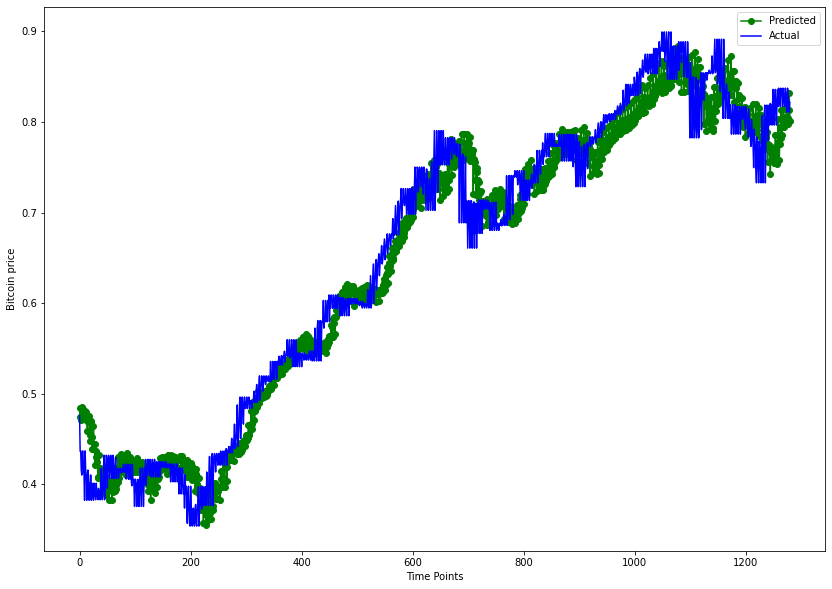

In [ ]:
plot_predictions(predict, values)

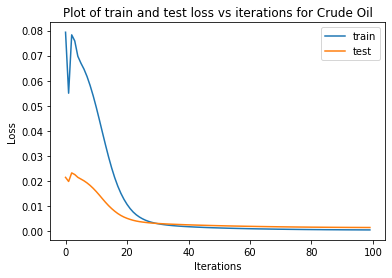

In [ ]:
plot_tr_te(iterations,tr,te,'Crude Oil')

# Bitcoin

In [ ]:
train_set, train_label, test_set, test_label, length_test = format_train_test(
                                                                batch_size=64,
                                                                data=coin_df,
                                                                percent=0.2,
                                                                num_predicts=5,
                                                                column_i=7
                                                                )

train_set, train_label, test_set, test_label = map(torch.tensor,(train_set, train_label, test_set, test_label))

train = TensorDataset(train_set, train_label)
train_tensor = DataLoader(train, batch_size = 64, shuffle=False)

test = TensorDataset(test_set, test_label)
test_tensor = DataLoader(test, batch_size= 64, shuffle=False)

#we then make train, test sets, and their labels. Then we convert them to torch tensors and make torch dataset and use DataLoader to 
#to make data ready for training and testing. Here batch size is 64, percent of test set is 0.2 and 5 predictions steps

In [ ]:
iterations, tr, te, predict, values = train_test(model,train_tensor,test_tensor,criterion,optimizer,device,64,100)

C:\Users\goodu\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64, 5, 1])) that is different to the input size (torch.Size([64, 5, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Iteration 0
********************
The loss for train is:  0.00940252747386694
The loss for test is:  0.02060311901004752
Iteration 1
********************
The loss for train is:  0.0067263757809996605
The loss for test is:  0.019490015532937832
Iteration 2
********************
The loss for train is:  0.007034459616988897
The loss for test is:  0.019466181140160188
Iteration 3
********************
The loss for train is:  0.0074675921350717545
The loss for test is:  0.019611506402725354
Iteration 4
********************
The loss for train is:  0.007993395440280437
The loss for test is:  0.019733995217393385
Iteration 5
********************
The loss for train is:  0.008178450167179108
The loss for test is:  0.019609598064562306
Iteration 6
********************
The loss for train is:  0.00812550075352192
The loss for test is:  0.019310966636112425
Iteration 7
********************
The loss for train is:  0.007951867766678333
The loss for test is:  0.01890155873115873
Iteration 8
**************

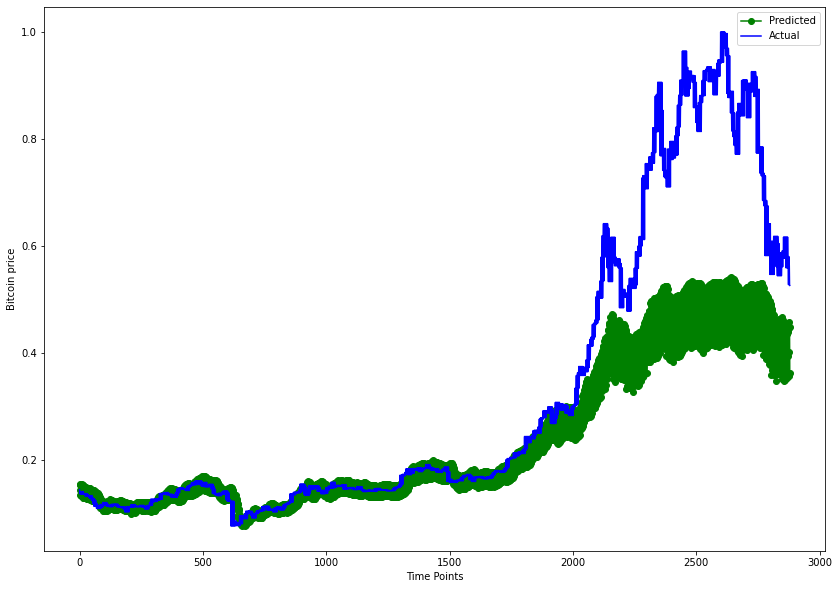

In [ ]:
plot_predictions(predict, values)

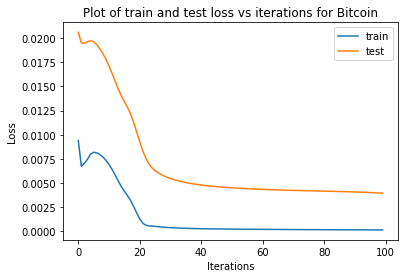

In [ ]:
plot_tr_te(iterations,tr,te,'Bitcoin')

# S&P 500

In [ ]:
train_set, train_label, test_set, test_label, length_test = format_train_test(
                                                                batch_size=64,
                                                                data=sp500_df,
                                                                percent=0.2,
                                                                num_predicts=5,
                                                                column_i=7
                                                                )

train_set, train_label, test_set, test_label = map(torch.tensor,(train_set, train_label, test_set, test_label))

train = TensorDataset(train_set, train_label)
train_tensor = DataLoader(train, batch_size = 64, shuffle=False)

test = TensorDataset(test_set, test_label)
test_tensor = DataLoader(test, batch_size= 64, shuffle=False)

#we then make train, test sets, and their labels. Then we convert them to torch tensors and make torch dataset and use DataLoader to 
#to make data ready for training and testing. Here batch size is 64, percent of test set is 0.2 and 5 predictions steps

In [ ]:
iterations, tr, te, predict, values = train_test(model,train_tensor,test_tensor,criterion,optimizer,device,64,100)

C:\Users\goodu\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64, 5, 1])) that is different to the input size (torch.Size([64, 5, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Iteration 0
********************
The loss for train is:  0.003434876911342144
The loss for test is:  0.016528737383850967
Iteration 1
********************
The loss for train is:  0.0056475624442100525
The loss for test is:  0.01797272475596401
Iteration 2
********************
The loss for train is:  0.0077084731310606
The loss for test is:  0.01922774833656149
Iteration 3
********************
The loss for train is:  0.007664885371923447
The loss for test is:  0.01925047134864144
Iteration 4
********************
The loss for train is:  0.0075622862204909325
The loss for test is:  0.019023699787794612
Iteration 5
********************
The loss for train is:  0.007337447255849838
The loss for test is:  0.01871378827127046
Iteration 6
********************
The loss for train is:  0.007075748406350613
The loss for test is:  0.018478669313481078
Iteration 7
********************
The loss for train is:  0.0069596790708601475
The loss for test is:  0.018429469029797474
Iteration 8
***************

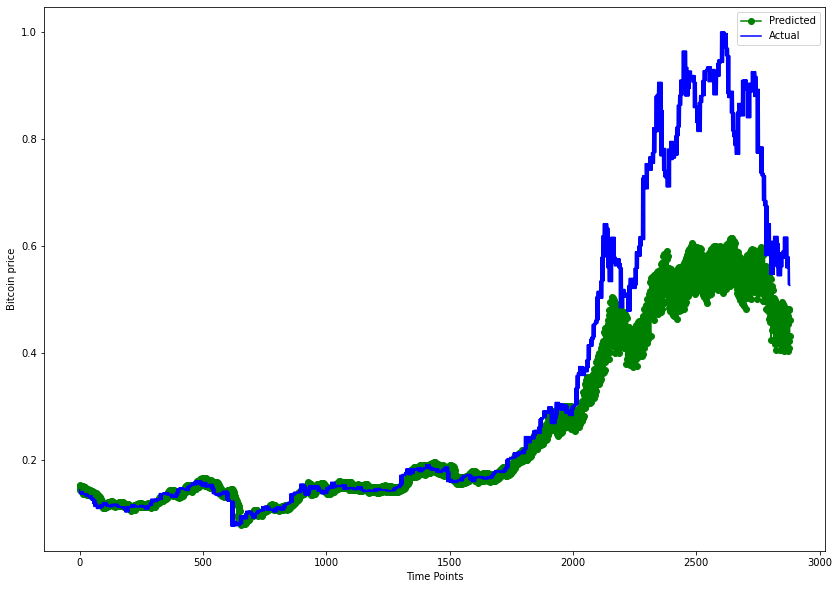

In [ ]:
plot_predictions(predict, values)

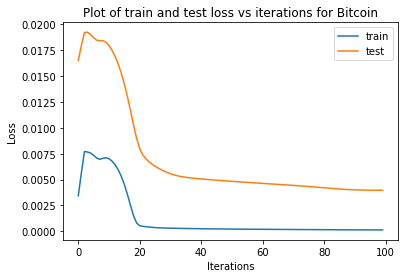

In [ ]:
plot_tr_te(iterations,tr,te,'S&P500 Index')